### Import libraries

In [173]:
import datetime
from collections import Counter
import pandas as pd
import seaborn as sns

In [174]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Settings

In [175]:
from settings import MarketDaysSettings

In [176]:
print(len(MarketDaysSettings.MarketHolidays))

191


### Core

#### Instrumentation

In [177]:
from core import Instrumentation

In [178]:
tracer = Instrumentation.startTracing("Hello()")
tracer.endTracing()

Hello() took 0 seconds


In [179]:
@Instrumentation.trace(name="test_tracing_decorator")
def test_tracing_decorator(task):
  print(f"I am doing {task}")

In [180]:
test_tracing_decorator("work")

I am doing work
test_tracing_decorator took 0 seconds


##### MarketDaysHelper

In [181]:
from core import MarketDaysHelper
from settings import MarketDaysSettings

MarketDaysHelper.is_open_for_day(datetime.date(2023, 1, 26))

False

In [182]:
MarketDaysHelper.get_this_or_next_market_day(datetime.date(2023, 5, 1))

datetime.date(2023, 5, 2)

In [183]:
MarketDaysHelper.get_this_or_previous_market_day(datetime.date(2023, 5, 1))

datetime.date(2023, 4, 28)

### DataReader

In [184]:
from data_reader import BhavCopyReader, DateRangeDataReader, NseIndicesReader
bhavReader = BhavCopyReader()
nseIndicesReader = NseIndicesReader()
dateRangeDataReader = DateRangeDataReader(bhavReader)


In [185]:
from_date = datetime.date(2023, 5, 1)
to_date = datetime.date(2023, 5, 5)
result = dateRangeDataReader.read(from_date, to_date)

### DataProcessor

In [186]:
from data_processor import HistoricalDataProcessor
historicalDataProcessor = HistoricalDataProcessor()

In [187]:
from data_processor import ManualDataProcessor
manualDataProcessor = ManualDataProcessor()

In [188]:
manual_data = manualDataProcessor.process(nseIndicesReader)

../manual_data\Indices
ManualDataProcessor.process took 11 seconds


#### Indices

In [190]:
from_date = datetime.date(1990, 1, 1)
to_date = datetime.date(2023, 5, 29)
#to_date = datetime.date.today()
result_indices = historicalDataProcessor.process(nseIndicesReader, {'from_date': from_date, 'to_date': to_date})

Started to read data
Reading from 2013-01-01 instead of 1990-01-01
get_data took 1 seconds
get_manual_data took 0 seconds
Started basic calculation
add_basic_calc took 0 seconds
Started periodic calculation for Year
add_yearly_growth_calc took 1 seconds
Started periodic calculation for Month


c:\Data\_Personal\Projects\markets-data-manager\src\data_processor.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  (x.min() - x.iloc[0]) / x.iloc[0] * 100
c:\Data\_Personal\Projects\markets-data-manager\src\data_processor.py:118: RuntimeWarning: invalid value encountered in double_scalars
  (x.min() - x.iloc[0]) / x.iloc[0] * 100
c:\Data\_Personal\Projects\markets-data-manager\src\data_processor.py:122: RuntimeWarning: invalid value encountered in double_scalars
  #pd.Series((x.max() - x.iloc[0]) / x.iloc[0] * 100 if x.iloc[0] > 0 else 0, dtype='float64')
c:\Data\_Personal\Projects\markets-data-manager\src\data_processor.py:127: RuntimeWarning: divide by zero encountered in double_scalars
  return periodic_grouped
c:\Data\_Personal\Projects\markets-data-manager\src\data_processor.py:127: RuntimeWarning: invalid value encountered in double_scalars
  return periodic_grouped


add_monthly_growth_calc took 10 seconds


#### Equities

In [191]:
from_date = datetime.date(2023, 5, 1)
to_date = datetime.date(2023, 5, 31)
#to_date = datetime.date.today()
result_equities = historicalDataProcessor.process(bhavReader, {'from_date': from_date, 'to_date': to_date})

Started to read data
get_data took 6 seconds
get_manual_data took 0 seconds
Started basic calculation
add_basic_calc took 1 seconds
Started periodic calculation for Year
add_yearly_growth_calc took 1 seconds
Started periodic calculation for Month
add_monthly_growth_calc took 2 seconds


#### Visualisation

In [192]:
#result = result_equities
result = result_indices

In [200]:
period = "Year"
label = "Annual"
period_grouped = result['yearly_grouped'].last().reset_index()

#period = "Month"
#label = "Monthly"
#period_grouped = result['monthly_grouped'].first().reset_index()

top5_gainers_ids = result['identifier_grouped'].last().reset_index().sort_values('Annual - Growth', ascending=False).head(5)['Identifier']
top5_gainers = period_grouped[period_grouped['Identifier'].isin(top5_gainers_ids)]

top5_looser_ids = result['identifier_grouped'].last().reset_index().sort_values('Annual - Growth', ascending=True).head(5)['Identifier']
top5_loosers = period_grouped[period_grouped['Identifier'].isin(top5_looser_ids)]

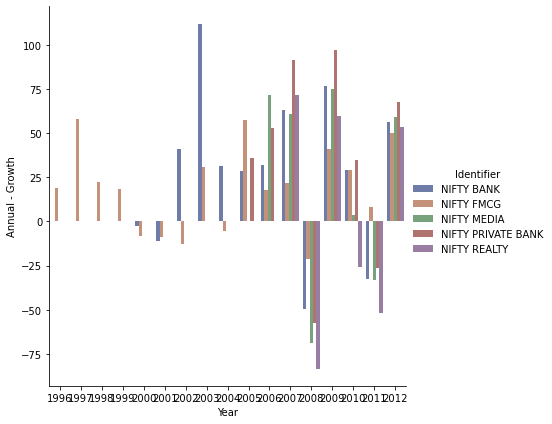

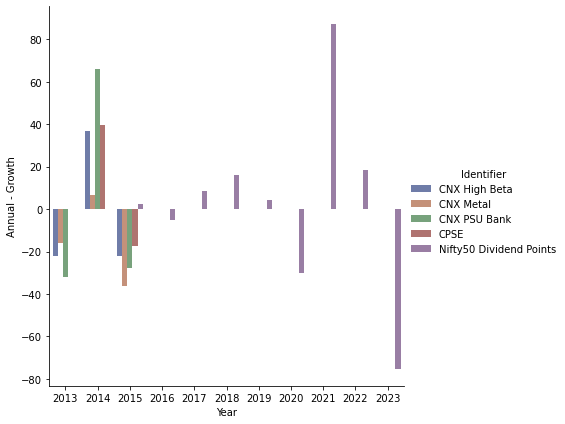

In [201]:
sns.catplot(x=period, y=label + " - Growth", 
  data=top5_gainers,
  kind="bar",
  hue="Identifier",
  palette="dark", alpha=.6, height=6
)
sns.catplot(x=period, y=label + " - Growth", 
  data=top5_loosers,
  kind="bar",
  hue="Identifier",
  palette="dark", alpha=.6, height=6
)

<AxesSubplot:xlabel='Year', ylabel='Annual - Growth'>

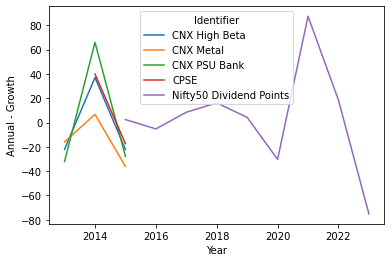

In [203]:
sns.lineplot(x=period, y="Annual - Growth", 
            hue="Identifier",
            data=top5_gainers)

sns.lineplot(x=period, y="Annual - Growth", 
             hue="Identifier",
             data=top5_loosers
            )

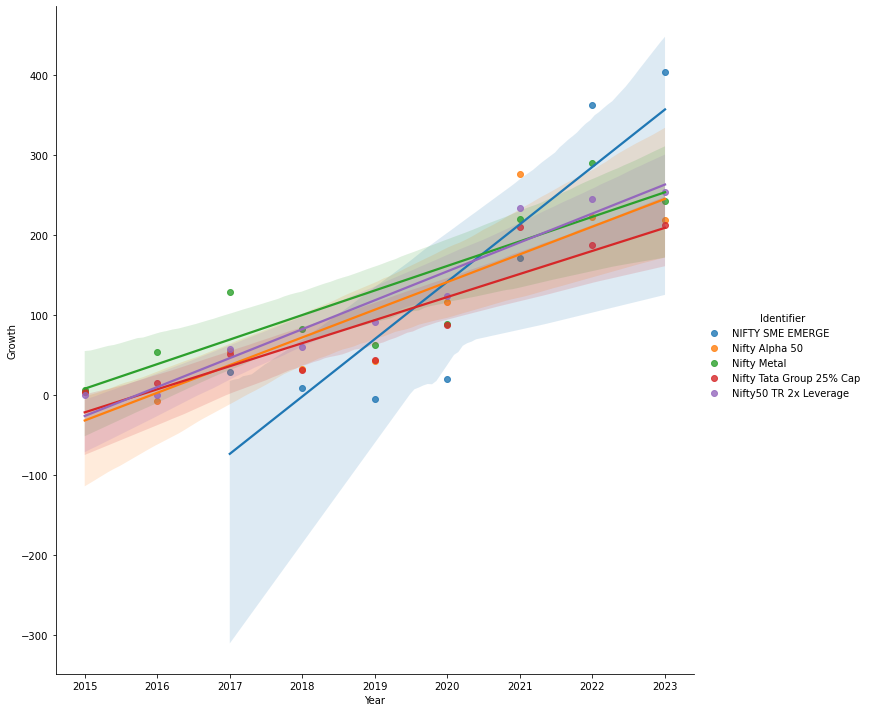

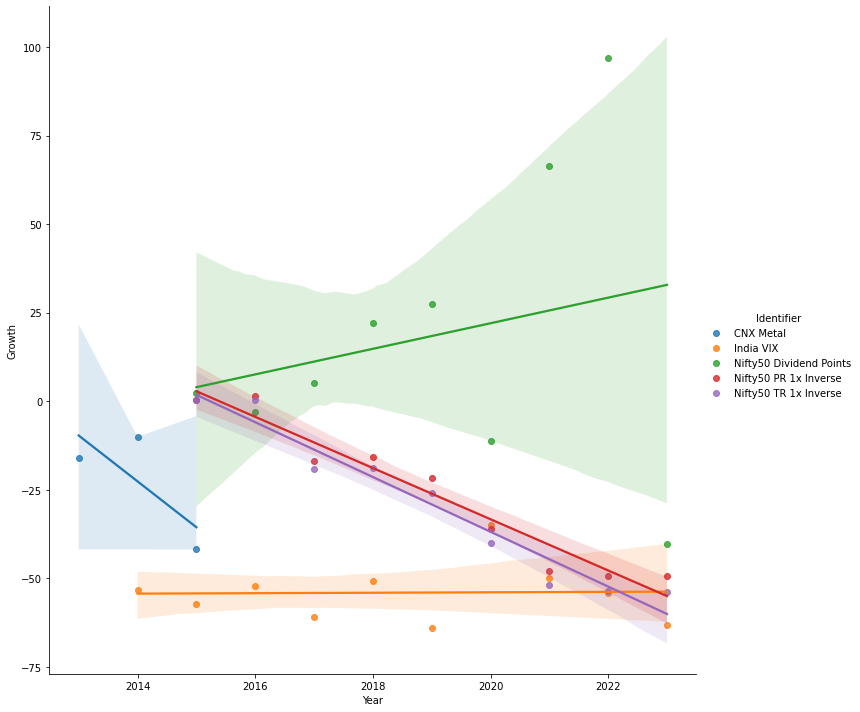

In [110]:
sns.lmplot(x=period, y="Growth", 
             hue="Identifier",
             data=top5_gainers,
    height=10
)
sns.lmplot(x=period, y="Growth", 
             hue="Identifier",
             data=top5_loosers,
    height=10
)

<AxesSubplot:xlabel='None-Year', ylabel='None-Year'>

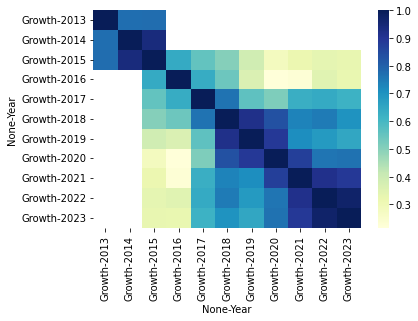

In [169]:
sns.heatmap(period_grouped[["Identifier", "Year", "Growth"]].pivot(index="Identifier", columns="Year", values=["Growth"]).corr(), cmap="YlGnBu", annot=False)

In [170]:
#period_grouped[["Identifier", "Year", "Growth"]].pivot_table(index=["Identifier"], columns=["Year"], values=["Growth"])
period_grouped[["Year", "Identifier", "Growth"]].pivot(index="Identifier", columns="Year", values="Growth").corr()

Year,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Year,,,,,,,,,,,
2013,1.000000,0.773048,0.774601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,0.773048,1.000000,0.940004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,0.774601,0.940004,1.000000,0.640502,0.554007,0.502239,0.388675,0.280582,0.319275,0.336785,0.327518
2016,NaN,NaN,0.640502,1.000000,0.634746,0.538238,0.363409,0.216095,0.226430,0.348257,0.325740
2017,NaN,NaN,0.554007,0.634746,1.000000,0.762162,0.561290,0.510502,0.629259,0.639698,0.619347
2018,NaN,NaN,0.502239,0.538238,0.762162,1.000000,0.919988,0.832168,0.732732,0.746410,0.701859
2019,NaN,NaN,0.388675,0.363409,0.561290,0.919988,1.000000,0.890518,0.709287,0.682157,0.649510
2020,NaN,NaN,0.280582,0.216095,0.510502,0.832168,0.890518,1.000000,0.875972,0.760989,0.766586
2021,NaN,NaN,0.319275,0.226430,0.629259,0.732732,0.709287,0.875972,1.000000,0.915900,0.892699
